About the homework: In some tasks, in addition to writing code, answers to questions and conclusions are required (there are special Markdown cells marked with **Answer**).

The ability to analyze the results of experiments is an important skill. Therefore, answers carry more weight than the code: the code accounts for 30% of the task grade, while answers to questions account for 70%.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Download the [UCI Heart Disease Data](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data/data)

In [5]:
df = pd.read_csv('archive.zip', compression='zip')
df.sample(4)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
387,388,46,Male,Hungary,asymptomatic,180.0,280.0,False,st-t abnormality,120.0,False,0.0,NaN,NaN,NaN,0
822,823,48,Male,VA Long Beach,non-anginal,102.0,0.0,NaN,st-t abnormality,110.0,True,1.0,downsloping,NaN,NaN,1
850,851,48,Male,VA Long Beach,non-anginal,132.0,220.0,True,st-t abnormality,162.0,False,0.0,NaN,NaN,fixed defect,1
648,649,55,Male,Switzerland,atypical angina,140.0,0.0,NaN,st-t abnormality,150.0,False,0.2,upsloping,NaN,NaN,0


# Task 1 (2 points)

Compute the mean, quartiles(Q1, Q2, Q3) and std for every numerical feature (also include column `'id'`).

In [6]:
df.describe()

,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


Let's look into `'id'` feature. Does it seem to differ from other variables? If yes, how?

<Axes: ylabel='id'>

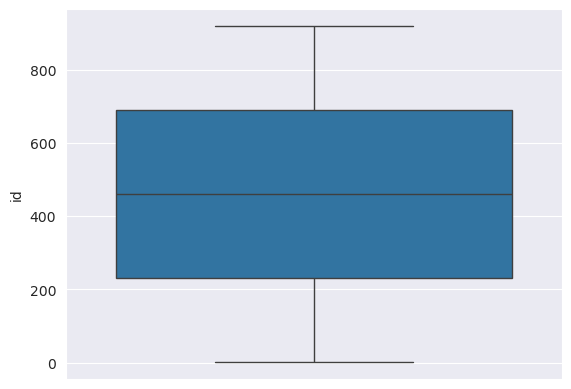

In [9]:
sns.boxplot(df['id'])

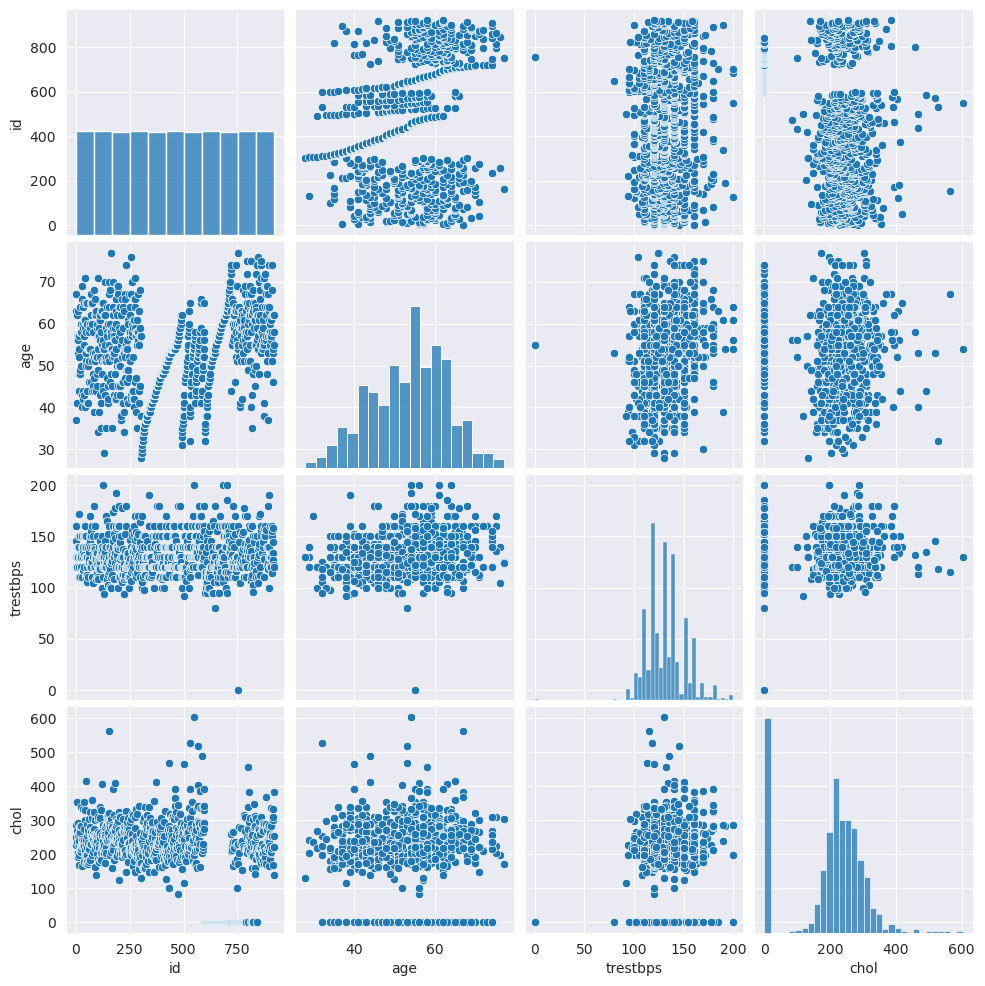

In [19]:
sns.pairplot(df[df.columns[:7]])

Yes, `id` is different because it has not distribution. All values are essentially unique:

In [21]:
print(df.shape[0])
print(len(df['id'].unique()))

920
920


Draw the distribution of the `'id'` variable. Describe it and explain, why does it look like this. What useful information about heart disease can be extracted from it?

Let's investigate possible relationships for heart disease. For that i'd like to make a correlation plot of all numeric variables

<Axes: >

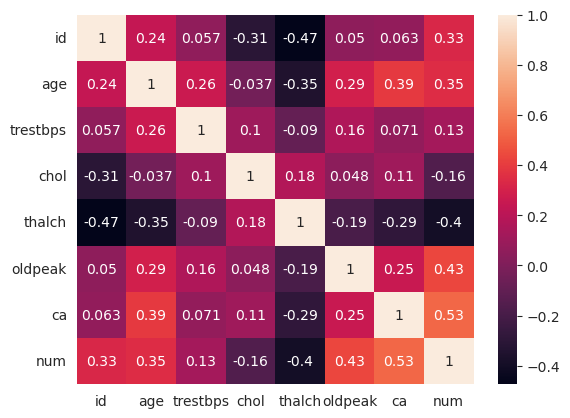

In [23]:
sns.heatmap(df.corr(method='spearman', numeric_only=True), annot=True)

As for target i assume we have `restecg - resting electrocardiographic results` which i assume actual diagnoses and `num` which is a   diagnoses for heat diseases. 

So we have 2 variables we can set as target but for outcome variable i'll use only num because we can imply that all other factors are influencing the `num`

Thus i propose 3 ways of analysis:

- bayesian networks - they can show us variables' relationships in for of DAGs with BIC as influence score.
- logistic regression that would show us odds ratios for different groups of people which is suitable for 2 outcomes: have heart disease and have not
- simple crosstabulations and chi-square for determening differences between groups

As a cool outcome we can even predict some patients. And that very cool 😎

# Task 2 (2 points)

Let's search for outliers in numerical variables (do not include `'id'`).

First of all, draw boxplots for every one of them on one figure.

Hint: use `plt.subplots`

Describe the plots:



*   Which features do not have any outliers?
*   Which features seem to have the maximum number of outliers?
*   For which features it may be hard to count the number of outliers? Why?





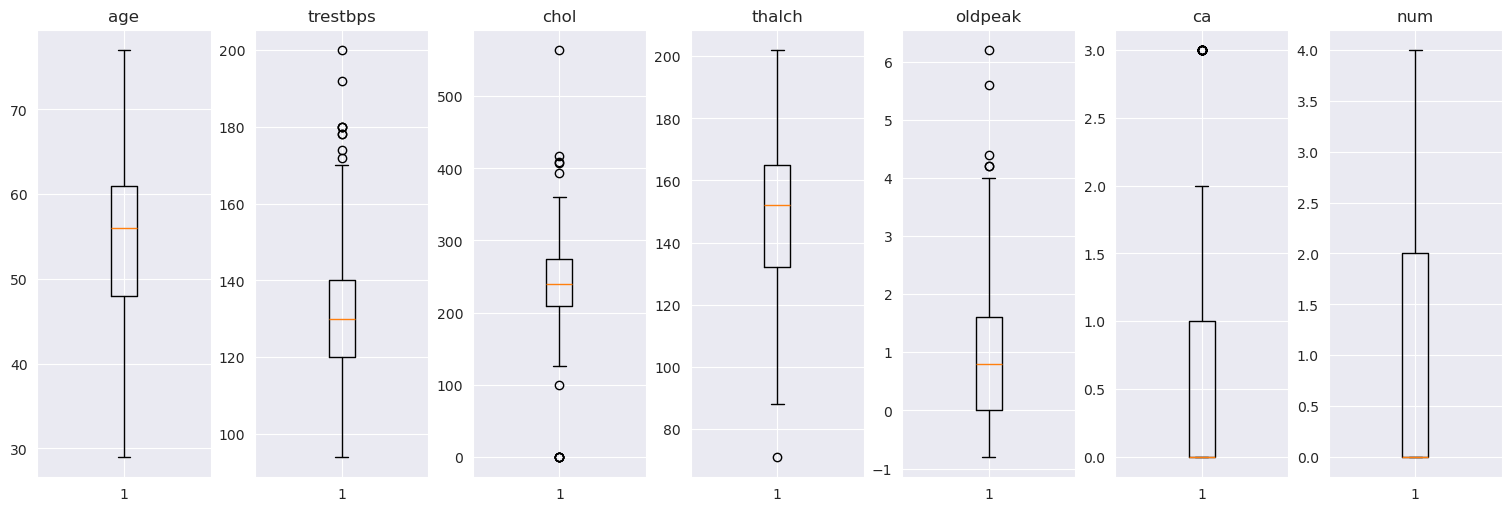

In [50]:
num_cols = []
for col in df.columns:
    _ = str(df[col].dtype)
    if ('int' in _ or 'float' in _) and col != 'id':
        num_cols.append(col)

df_num = df[num_cols].dropna()

fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(15, 5), constrained_layout=True)

# Plot each column in a separate subplot
for i, col in enumerate(df_num.columns):
    axes[i].boxplot(df_num[col])
    axes[i].set_title(col)

plt.show()

- No outliers: i suppose `age` and `num` because obviously we don't see them
- maybe `trestbps`, `chol` and `oldpeak`. Pictures show multiple outliers on different levels 
- `ca` a and `thalch` because some outliers are in the same space for multiple observations 

Use the $1.5IQR$ approach and count the number of outliers for each column.

In [71]:
# okay, let's make a function for 1.5IQR

def get_outliers(frame: pd.DataFrame, col: str) -> tuple:
    Q1 = frame[col].quantile(0.25)
    Q3 = frame[col].quantile(0.75)
    IQR = Q3 - Q1

    lwr_bound = Q1 - 1.5 * IQR
    upr_bound = Q3 + 1.5 * IQR
    outliers = frame[(frame[col] < lwr_bound) | (frame[col] > upr_bound)]

    return outliers.shape[0], lwr_bound, upr_bound

for col in df_num.columns:
    print(f'column {col} has {get_outliers(df_num, col)[0]} outliers')

column age has 0 outliers
column trestbps has 9 outliers
column chol has 12 outliers
column thalch has 1 outliers
column oldpeak has 5 outliers
column ca has 20 outliers
column num has 0 outliers


For the feature with most outliers, draw the histogram and depict the bounds. Do the bounds seem too tight or too wide? Is deleting all outliers for this feature a good idea?

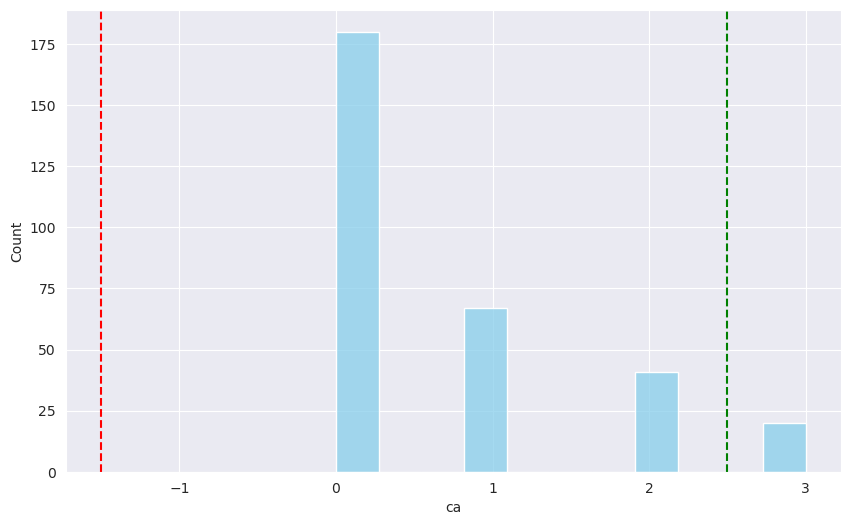

In [69]:
plt.figure(figsize=(10, 6))
sns.histplot(df_num['ca'], color="skyblue")
plt.axvline(get_outliers(df_num, 'ca')[1], color='red', linestyle='--', linewidth=1.5)
plt.axvline(get_outliers(df_num, 'ca')[2], color='green', linestyle='--', linewidth=1.5)


Left boundary is wide and even goes outside scale. The right boundary is just fine. Deleting may be a good idea because there's a significant distance between right bound and outliers 

# Task 3 (2 points)

Find the group (or groups) of people that will be deleted, if we delete all the outliers for the feature with the most outliers from the previous task.

In [73]:
# like for wording 
df_excluded = df.loc[df['ca'] > get_outliers(df_num, 'ca')[2]]
df_excluded

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
40,41,65,Female,Cleveland,asymptomatic,150.0,225.0,False,lv hypertrophy,114.0,False,1.0,flat,3.0,reversable defect,4
62,63,58,Male,Cleveland,asymptomatic,128.0,216.0,False,lv hypertrophy,131.0,True,2.2,flat,3.0,reversable defect,1
91,92,62,Female,Cleveland,asymptomatic,160.0,164.0,False,lv hypertrophy,145.0,False,6.2,downsloping,3.0,reversable defect,3
92,93,62,Male,Cleveland,non-anginal,130.0,231.0,False,normal,146.0,False,1.8,flat,3.0,reversable defect,0
104,105,49,Male,Cleveland,non-anginal,120.0,188.0,False,normal,139.0,False,2.0,flat,3.0,reversable defect,3
118,119,63,Male,Cleveland,asymptomatic,130.0,330.0,True,lv hypertrophy,132.0,True,1.8,upsloping,3.0,reversable defect,3
121,122,63,Female,Cleveland,asymptomatic,150.0,407.0,False,lv hypertrophy,154.0,False,4.0,flat,3.0,reversable defect,4
146,147,57,Male,Cleveland,asymptomatic,165.0,289.0,True,lv hypertrophy,124.0,False,1.0,flat,3.0,reversable defect,4
155,156,70,Male,Cleveland,asymptomatic,130.0,322.0,False,lv hypertrophy,109.0,False,2.4,flat,3.0,normal,1


let's make crosstabs for categorical variables so we can see the difference better

In [82]:

pd.crosstab(df_excluded['sex'], [df_excluded['restecg'], df_excluded['thal']], df_excluded['num'], aggfunc='count', normalize='columns') * 100

restecg lv hypertrophy                         normal         \
thal            normal reversable defect fixed defect normal   
sex                                                            
Female             0.0              37.5          0.0  100.0   
Male             100.0              62.5        100.0    0.0   

restecg                   st-t abnormality  
thal    reversable defect     fixed defect  
sex                                         
Female                0.0              0.0  
Male                100.0            100.0

So by excluding outliers we'll exclude some males with higher lv hypertrophy for `restecg` and normal `thal` + males with st-t abnormality and fixed defect


# Task 4 (2 points)

Check the proportion of missing values in the dataset. What approach can be used to tackle the problem for every variable?

In [85]:
print(df.isna().mean())

id          0.000000
age         0.000000
sex         0.000000
dataset     0.000000
cp          0.000000
trestbps    0.064130
chol        0.032609
fbs         0.097826
restecg     0.002174
thalch      0.059783
exang       0.059783
oldpeak     0.067391
slope       0.335870
ca          0.664130
thal        0.528261
num         0.000000
dtype: float64


for example we can predict possible variables and place them or maybe mean value but in practice it's better just to remove missing observations

Fill the missing values, for categorical features create new category `'NOT GIVEN'`

In [89]:
# i don't think really i got this as intended 
fill_dict = {'int': 0, 'float': 0, 'object': 'NOT GIVEN'}

df[num_cols] = df[num_cols].fillna(0)
df[df.columns.difference(num_cols)] = df[df.columns.difference(num_cols)].fillna("NOT GIVEN")
df

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,Female,VA Long Beach,asymptomatic,127.0,333.0,True,st-t abnormality,154.0,False,0.0,NOT GIVEN,0.0,NOT GIVEN,1
916,917,62,Male,VA Long Beach,typical angina,0.0,139.0,False,st-t abnormality,0.0,NOT GIVEN,0.0,NOT GIVEN,0.0,NOT GIVEN,0
917,918,55,Male,VA Long Beach,asymptomatic,122.0,223.0,True,st-t abnormality,100.0,False,0.0,NOT GIVEN,0.0,fixed defect,2
918,919,58,Male,VA Long Beach,asymptomatic,0.0,385.0,True,lv hypertrophy,0.0,NOT GIVEN,0.0,NOT GIVEN,0.0,NOT GIVEN,0


# Task 5 (2 points)

Convert every numerical variable into z-scores:

In [90]:
from scipy.stats import zscore

df_num_zcored = df_num.apply(zscore)
df_num_zcored

,age,trestbps,chol,thalch,oldpeak,ca,num
0,0.932921,0.754438,-0.136594,0.051960,1.086111,-0.725856,-0.774831
1,1.378928,1.604146,0.716741,-1.764677,0.392801,2.483193,0.854166
2,1.378928,-0.661743,-0.200997,-0.856358,1.346102,1.413510,0.039667
3,-1.966122,-0.095270,0.137117,1.652331,2.126076,-0.725856,-0.774831
4,-1.520115,-0.095270,-0.603513,1.003532,0.306137,-0.725856,-0.774831
...,...,...,...,...,...,...,...
676,0.598416,-0.095270,-3.888047,-0.813105,0.046146,0.343827,0.039667
691,0.821420,-0.661743,-3.888047,-0.640092,-1.600466,1.413510,0.039667
717,1.936436,1.604146,-3.888047,-1.505157,0.479464,1.413510,-0.774831
748,0.152410,-0.661743,-2.277981,-1.245638,0.392801,-0.725856,0.039667


Find the most extreme value in the dataset: in what column is it in?

In [104]:
df_num_zcored = df_num_zcored.abs()

print(f'extreme value: {df_num_zcored.max().max()}')

print(f'column with extreme value: {df_num_zcored.max().idxmax()}')

extreme value: 5.19272297941604
column with extreme value: chol


it's in chol with 5.19 z score. THE WINNER

Draw the distributions on one plot. Adjust the visible area of the histogram in such way, that the bar for the most extreme value is visible. It is ok to cut  very high bars.

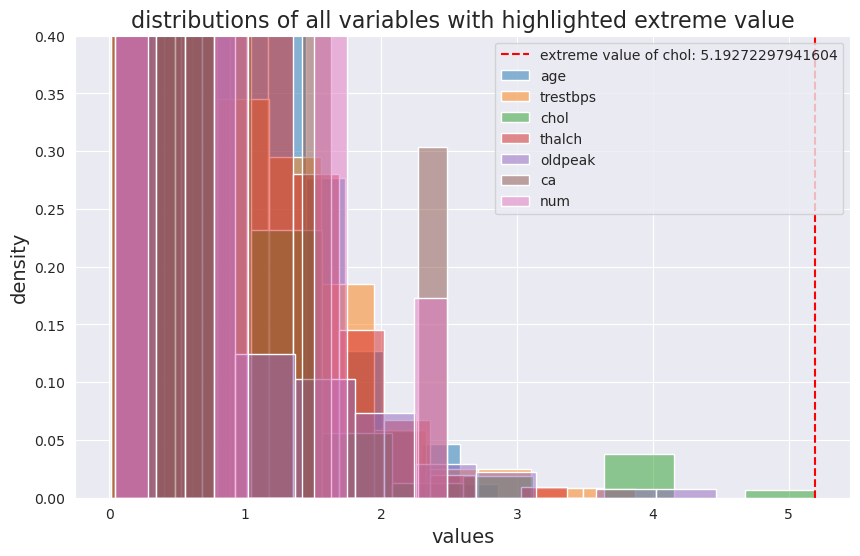

In [116]:
plt.figure(figsize=(10, 6))

for column in df_num_zcored.columns:
    sns.histplot(df_num_zcored[column], bins=10, stat="density", label=column, alpha=0.5)

highlight_var = 'chol'
max_value = df_num_zcored[highlight_var].max()

plt.axvline(x=max_value, color='red', linestyle='--', label=f'extreme value of {highlight_var}: {max_value}')

plt.ylim(0, 0.4)

plt.title('distributions of all variables with highlighted extreme value', fontsize=16)
plt.xlabel('values', fontsize=14)
plt.ylabel('density', fontsize=14)

plt.legend()

plt.show()

it's okay to cut bars if we want to "zoom in" the picture